In [45]:
import pandas as pd
import networkx as nx
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly as py
import operator
from fa2 import ForceAtlas2
import matplotlib.colors as pltcolors
from community import community_louvain
import seaborn as sns
import re

In [46]:
neg_books = pd.read_pickle("negative_books.pcl")
pos_books = pd.read_pickle("books.pcl")
pos_books_reviewed = pos_books[pos_books.review.notna()]

In [47]:
neg_books = neg_books.reset_index(drop=True)
pos_books_reviewed = pos_books_reviewed.reset_index(drop=True)

In [48]:
def create_review_df(df, tag):
    df_out = []
    idx = []
    for i in range(len(df)):
        for j in range(len(df.review[i][0])):
            df_out.append(df.review[i][0][j])
            idx.append(i)
    df_out = pd.DataFrame(df_out)
    idx = pd.DataFrame(idx)
    df_out["pos"] = tag
    df_out["idx_original"] = idx
    return df_out

In [49]:
pos_df = create_review_df(pos_books_reviewed, 1)
neg_df = create_review_df(neg_books, 0)

In [52]:
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import enchant

tokenizer = RegexpTokenizer(r"\w+")
stopwords = nltk.corpus.stopwords.words("english")
dictionary_us = enchant.Dict("en_US")

In [53]:
def clean_text_simple(df, dictionary):
    for i, review in enumerate(df[0]):
        rev = re.sub("(\\n\s*)", "", review)
        
        #Removing links
        rev = re.sub(r"(https:\/\/.*)", r' ', rev)
        
        #Removing numbers
        #rev = re.sub(r"\d+", r" ", rev)
        
        #Removing non-Roman letters
        #rev = re.sub(r"[^A-Z a-z]", r"", rev)
        
        #rev = [w for w in rev if dictionary.check(w)]
        #rev = " ".join(rev)
        
        df.iloc[i,0] = [rev]
    return df

In [54]:
pos_cleaned = clean_text_simple(pos_df, dictionary_us)
neg_cleaned = clean_text_simple(neg_df, dictionary_us)

In [56]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [57]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [58]:
pos_scored = pos_cleaned[0].apply(lambda x: sentiment_analyzer_scores(x))
neg_scored = neg_cleaned[0].apply(lambda x: sentiment_analyzer_scores(x))

In [59]:
def unpack_dict(lst):
    df = pd.DataFrame(lst)
    df["neg"] = [x.get("neg") for x in df[0]]
    df["neu"] = [x.get("neu") for x in df[0]]
    df["pos"] = [x.get("pos") for x in df[0]]
    df["compound"] = [x.get("compound") for x in df[0]]
    return df

In [60]:
pos_scored = unpack_dict(pos_scored)
neg_scored = unpack_dict(neg_scored)

In [61]:
pos_scored["idx_original"] = pos_df["idx_original"]
neg_scored["idx_original"] = neg_df["idx_original"]

In [62]:
pos_final = pos_scored.groupby("idx_original")["compound"].mean()
neg_final = neg_scored.groupby("idx_original")["compound"].mean()

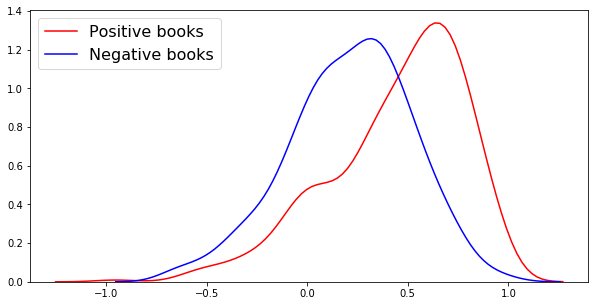

In [63]:
plt.figure(figsize = (10,5))
sns.kdeplot(pos_final, color = 'red')
sns.kdeplot(neg_final, color = 'blue')
#plt.xlabel('Outgoing Strength', fontsize = 14)
#plt.ylabel('Count', fontsize = 14)
#plt.title('Distribution of sentiment for the Two Parties', fontsize = 18)
plt.legend(['Positive books', 'Negative books'], fontsize = 16)
plt.show()

In [71]:
pos_final.mean()

0.44508081447963804

In [72]:
neg_final.mean()

0.20988099293895615

In [64]:
neg_books.rating = pd.to_numeric(neg_books["rating"])

In [66]:
pos_extreme = pd.DataFrame(pos_final)
pos_extreme["tag"] = 1
neg_extreme = pd.DataFrame(neg_final)
neg_extreme["tag"] = 0

In [67]:
combined = pd.concat([pos_extreme, neg_extreme]).reset_index()

In [68]:
mean_sent = combined["compound"].mean()
std_sent = combined["compound"].std()

In [73]:
mean_sent

0.33423305169611095

In [74]:
std_sent

0.34448673435372784

{'whiskers': [<matplotlib.lines.Line2D at 0x133b25668>,
 'caps': [<matplotlib.lines.Line2D at 0x133b25d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x133b25518>],
 'medians': [<matplotlib.lines.Line2D at 0x133b2e400>],
 'fliers': [<matplotlib.lines.Line2D at 0x133b2e748>],
 'means': []}

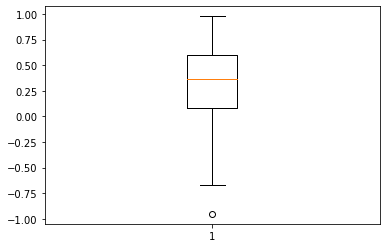

In [76]:
plt.boxplot(combined["compound"])

In [80]:
import numpy as np
thres = np.percentile(combined["compound"], 75)-np.percentile(combined["compound"], 25)

In [82]:
np.percentile(combined["compound"], 25)-(thres * 1.5)

-0.6884933333333333

In [83]:
np.percentile(combined["compound"], 75)+(thres * 1.5)

1.37508

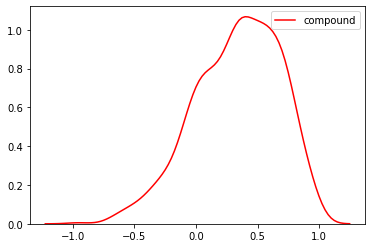

In [84]:
sns.kdeplot(combined["compound"], color = 'red')

In [86]:
np.median(combined["compound"])

0.36383000000000004

In [99]:
thres_high = np.percentile(combined["compound"], 95)
thres_low = np.percentile(combined["compound"], 5)

In [100]:
really_good_from_good = pos_final[pos_final > thres_high]
really_good_from_bad = neg_final[neg_final > thres_high]
really_bad_from_good = pos_final[pos_final < thres_low]
really_bad_from_bad = neg_final[neg_final < thres_low]

In [101]:
print(f"A total of {len(really_good_from_good)} books from the positive list score as positive")
print(f"A total of {len(really_good_from_bad)} books from the negative list score as positive")
print(f"A total of {len(really_bad_from_good)} books from the positive list score as negative")
print(f"A total of {len(really_bad_from_bad)} books from the negative list score as negative")

A total of 38 books from the positive list score as positive
A total of 4 books from the negative list score as positive
A total of 14 books from the positive list score as negative
A total of 28 books from the negative list score as negative


In [115]:
all_pos = pd.concat([pos_books_reviewed.iloc[really_good_from_good.index,:], neg_books.iloc[really_good_from_bad.index,:]])
all_neg = pd.concat([pos_books_reviewed.iloc[really_bad_from_good.index,:], neg_books.iloc[really_bad_from_bad.index,:]])
                     

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [119]:
def combine_reviews(df_w_reviews, dictionary):
    '''
    Function creating one large document of all tokens in entries in parsed dataframe.
    
    Parameters:
    df_w_reviews: Dataframe including list of individual reviews as entries. 
    
    Values:
    words: list of all tokens from df_w_reviews
    
    '''
    
    words = []

    for book in df_w_reviews.review:
        comb_reviews = ''
        for i in range(len(book[0])):
            rev = book[0][i]
            comb_reviews += rev
        
        #Removing '\n'
        comb_reviews = re.sub(r"(\\n)", r'', comb_reviews)
        
        #Removing links
        comb_reviews = re.sub(r"(https:\/\/.*)", r' ', comb_reviews)
        
        #Removing numbers
        comb_reviews = re.sub(r"\d+", r" ", comb_reviews)
        
        #Removing non-Roman letters
        comb_reviews = re.sub(r"[^A-Z a-z]", r"", comb_reviews)
        
        #Tokenize text
        tokens = tokenizer.tokenize(comb_reviews)
        
        #Remove punctuation
        no_punc = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
        no_punc = [s for s in no_punc if s]
        
        # remove all stopwords and make all tokens lower case 
        tmp = [w.lower() for w in no_punc if w.lower() not in stopwords]
        
        words += tmp
    words = [w for w in words if dictionary.check(w)]
    return words

In [120]:
# Getting all tokens from postive list and negative list
pos_cloud = combine_reviews(all_pos, dictionary_us)
neg_cloud = combine_reviews(all_neg, dictionary_us)

In [121]:
print(f"The document generated for the good books contains {len(pos_cloud):,} tokens")
print(f"The document generated for the bad books contains {len(neg_cloud):,} tokens")

The document generated for the good books contains 117,967 tokens
The document generated for the bad books contains 95,400 tokens


In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_list(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=vectorize_list,
    preprocessor=vectorize_list,
    token_pattern=None, 
    norm='l2',
    min_df=0, 
    use_idf=True, 
    smooth_idf=False, 
    sublinear_tf=True) 

vectors = tfidf.fit_transform([pos_cloud, neg_cloud])

In [124]:
feature_names = tfidf.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [126]:
pos = dict(df.iloc[0,:])
neg = dict(df.iloc[1,:])

In [141]:
from wordcloud import WordCloud
def gen_wordcloud(d, title):
    wordcloud = WordCloud(background_color="white",
                    colormap="gnuplot")
    wordcloud.generate_from_frequencies(frequencies=d)
    fig = plt.figure(figsize = (10,20))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(title, fontsize = 20)
    plt.show()

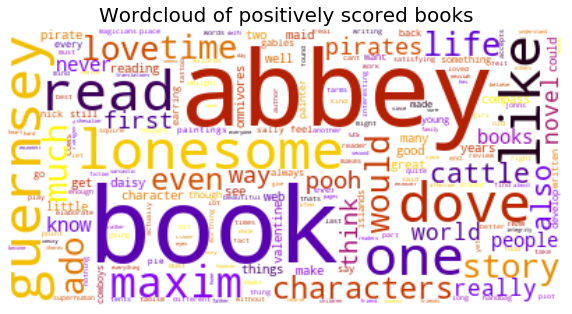

In [142]:
gen_wordcloud(pos, 'Wordcloud of positively scored books')

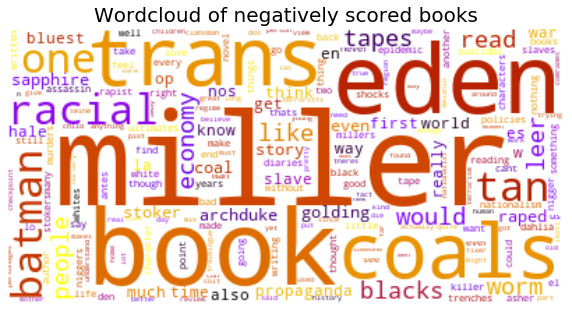

In [143]:
gen_wordcloud(neg, 'Wordcloud of negatively scored books')

In [137]:
# We will now look at the TF-IDF (term frequencyâ€“inverse document frequency) for the two documents we just created.
# To find the TFIDF the TF and IDF functions are first defined seperately. 
import math

def TF(word_list):
    fdist = nltk.FreqDist(word_list)
    words = np.array(list(fdist.keys()))
    count = np.array(list(fdist.values()))
    tf = count/len(word_list)
    df_tf = pd.DataFrame(data = {'words': words, 'count': count, 'tf': tf}).sort_values("tf", ascending=False)
    return df_tf

# We now turn to inverse document frequency
def IDF(documents):
    N = len(documents)
    combined = []
    for doc in documents:
        combined += doc
    words = pd.DataFrame(data = {"words": list(set(combined)), "idf": np.ones(len(set(combined)))})
    for i, word in enumerate(words["words"]):
        dft = 0
        for doc in documents:
            if word in doc:
                dft += 1
        words["idf"][i] = math.log(N/dft)
    return words

def TFIDF(documents):
    words = IDF(documents)
    tfidf = []
    for doc in documents:
        tf = TF(doc)
        tf = pd.merge(tf, words, on = "words")
        tf["tfidf"] = tf["tf"]*tf["idf"]
        tf = tf.sort_values("tfidf", ascending=False)
        d = tf[["words", "tfidf"]].set_index("words")
        d = d.to_dict()
        tfidf.append(d)
    return tfidf

In [139]:
documents = [pos_cloud, neg_cloud]

In [140]:
tfidf = TFIDF(documents)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
tfidf_pos = tfidf[0]
tfidf_neg = tfidf[1]

In [144]:
def gen_wordcloud(d, title):
    wordcloud = WordCloud(background_color="white",
                    colormap="gnuplot")
    wordcloud.generate_from_frequencies(frequencies=list(d.values())[0])
    fig = plt.figure(figsize = (10,20))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(title, fontsize = 20)
    plt.show()

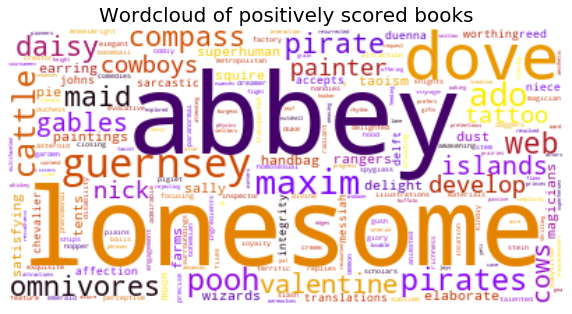

In [147]:
gen_wordcloud(tfidf_pos, 'Wordcloud of positively scored books')

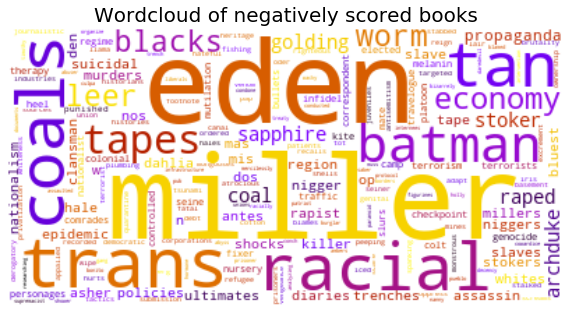

In [148]:
gen_wordcloud(tfidf_neg, 'Wordcloud of negatively scored books')